In [1]:
!pip install optax

In [ ]:
import numpy as np
import pandas as pd
import torch

np.random.seed(7)
torch.manual_seed(7)
key = random.PRNGKey(7)

# Generate random values
a_values = np.random.uniform(-10, 10, 500)
b_values = np.random.uniform(-10, 10, 500)
c_values = np.random.uniform(-10, 10, 500)
y_values = 5*a_values**2 + 2*b_values**2 + 4*c_values**2 + 7


df = pd.DataFrame({'a': a_values, 'b': b_values, 'c': c_values, 'y': y_values})

x = df.drop('y', axis=1).to_numpy()
y = df['y'].to_numpy().reshape(-1, 1)

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad
import optax  # Import optax for optimizers

# Initialize parameters of a linear layer
def init_linear_layer(key, input_dim, output_dim):
    w_key, b_key = random.split(key)
    weights = random.normal(w_key, (input_dim, output_dim)) * jnp.sqrt(2. / input_dim)
    biases = jnp.zeros(output_dim)
    return weights, biases

# Forward pass through a linear layer
def linear_forward(x, weights, biases):
    return jnp.dot(x, weights) + biases

# ReLU activation function
def relu(x):
    return jnp.maximum(0, x)

# Mean squared error loss function
def mae_loss(y_pred, y_true):
    return jnp.mean(jnp.abs(y_pred - y_true))

# Model definition (chaining of layers and activations)
def model(params, x):
    w1, b1, w2, b2, w3, b3 = params  # This line now correctly matches the flat structure of params
    x = relu(linear_forward(x, w1, b1))
    x = relu(linear_forward(x, w2, b2))
    x = linear_forward(x, w3, b3)
    return x

# Loss function for the model
def loss_fn(params, x, y):
    y_pred = model(params, x)
    return mae_loss(y_pred, y)


# Initialize model parameters
key, *subkeys = random.split(key, 6)
# Flatten the parameters
params = [init_linear_layer(subkeys[0], 3, 20)[0], init_linear_layer(subkeys[0], 3, 20)[1],  # Weights and biases for Layer 1
          init_linear_layer(subkeys[1], 20, 20)[0], init_linear_layer(subkeys[1], 20, 20)[1], # Weights and biases for Layer 2
          init_linear_layer(subkeys[2], 20, 1)[0], init_linear_layer(subkeys[2], 20, 1)[1]]   # Weights and biases for Layer 3

# Training loop using optax
def train(x, y, params, lr, num_epochs):
    optimizer = optax.sgd(lr)
    opt_state = optimizer.init(params)

    for epoch in range(num_epochs):
        def step(params, opt_state, x, y):
            grads = grad(loss_fn)(params, x, y)
            updates, opt_state = optimizer.update(grads, opt_state)
            new_params = optax.apply_updates(params, updates)
            return new_params, opt_state

        params, opt_state = step(params, opt_state, x, y)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss_fn(params, x, y)}')

    return params

# Train the model
final_params = train(x, y, params, lr=0.001, num_epochs=15000)

Epoch 0, Loss: 389.1744079589844
Epoch 100, Loss: 313.6622314453125
Epoch 200, Loss: 77.62999725341797
Epoch 300, Loss: 63.31211853027344
Epoch 400, Loss: 59.87904357910156
Epoch 500, Loss: 58.449459075927734
Epoch 600, Loss: 57.39903259277344
Epoch 700, Loss: 56.491878509521484
Epoch 800, Loss: 55.69689178466797
Epoch 900, Loss: 54.915985107421875
Epoch 1000, Loss: 54.19857406616211
Epoch 1100, Loss: 53.48664474487305
Epoch 1200, Loss: 52.81229782104492
Epoch 1300, Loss: 52.14289474487305
Epoch 1400, Loss: 51.46250915527344
Epoch 1500, Loss: 50.73276901245117
Epoch 1600, Loss: 49.94466018676758
Epoch 1700, Loss: 49.127525329589844
Epoch 1800, Loss: 48.296417236328125
Epoch 1900, Loss: 47.47956848144531
Epoch 2000, Loss: 46.649261474609375
Epoch 2100, Loss: 45.776649475097656
Epoch 2200, Loss: 44.89714431762695
Epoch 2300, Loss: 44.02925109863281
Epoch 2400, Loss: 43.16901779174805
Epoch 2500, Loss: 42.27302169799805
Epoch 2600, Loss: 41.330810546875
Epoch 2700, Loss: 40.33921432495117

In [ ]:
# Predictions
y_pred = model(final_params, x)

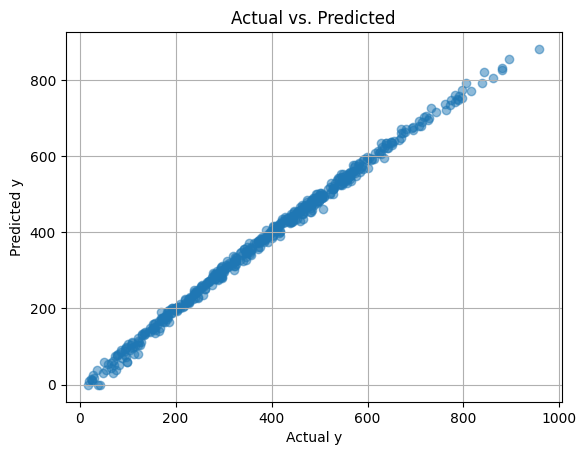

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.grid(True)
plt.show()